# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


This pattern is also noted when taking the mean value of each patch across the dataset.

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.

The first few cells are the code that was given to us, so that this section can be self-contained.  However, I modified them so that the test data would be loaded and prepared as well.

In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
    

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

In [4]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [5]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val, test = map(merge_data, [train_files, val_files,test_files])

CPU times: user 32.1 s, sys: 52.3 s, total: 1min 24s
Wall time: 9min 1s


In [6]:
client.shutdown()

In [7]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)
test_in, test_out = prepare_data(test)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)
scaled_test_in = scaler.transform(test_in)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


CPU times: user 25.5 s, sys: 6.34 s, total: 31.9 s
Wall time: 31.6 s


In [8]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

Starting here is my own code.  I train and test three types of models and record the performance on the validation and test sets.

In [9]:
#Define a few more metrics for classification

def precision(conf_mtx):
    """Returns precision metric"""
    return conf_mtx[1,1] / (conf_mtx[1,1]+conf_mtx[0,1])
def recall(conf_mtx):
    """Returns recall metric"""
    return conf_mtx[1,1] / (conf_mtx[1,1]+conf_mtx[1,0])
def accuracy(conf_mtx):
    """Returns accuracy"""
    return (conf_mtx[1,1]+conf_mtx[0,0])/conf_mtx.sum()
def f1(conf_mtx):
    """Returns f1"""
    return 2*precision(conf_mtx)*recall(conf_mtx)/(precision(conf_mtx)+recall(conf_mtx))

In [10]:
#Compute statistics of bands to use an input for decision tree-based models

train_band_std=np.std(scaled_train_in,axis=(1,2))
train_band_min=np.min(scaled_train_in,axis=(1,2))
train_band_mean=np.mean(scaled_train_in,axis=(1,2))
train_band_median=np.median(scaled_train_in,axis=(1,2))

val_band_std=np.std(scaled_val_in,axis=(1,2))
val_band_min=np.min(scaled_val_in,axis=(1,2))
val_band_mean=np.mean(scaled_val_in,axis=(1,2))
val_band_median=np.median(scaled_val_in,axis=(1,2))

test_band_std=np.std(scaled_test_in,axis=(1,2))
test_band_min=np.min(scaled_test_in,axis=(1,2))
test_band_mean=np.mean(scaled_test_in,axis=(1,2))
test_band_median=np.median(scaled_test_in,axis=(1,2))

train_std_min=np.concatenate((train_band_std,train_band_min),axis=1)
val_std_min=np.concatenate((val_band_std,val_band_min),axis=1)
test_std_min=np.concatenate((test_band_std,test_band_min),axis=1)

train_std_min_median=np.concatenate((train_std_min,train_band_median),axis=1)
val_std_min_median=np.concatenate((val_std_min,val_band_median),axis=1)
test_std_min_median=np.concatenate((test_std_min,test_band_median),axis=1)

Decision Tree with depth=1, Validation Set
Heidke Skill Score: 0.679
Pierce Skill Score: 0.678
Brier Score: 0.153
Brier Skill Score: 0.358
AUC: 0.839
Accuracy: 0.847
Precision: 0.809
Recall: 0.801
F1: 0.805

Decision Tree with depth=1, Test Set
Heidke Skill Score: 0.673
Pierce Skill Score: 0.667
Brier Score: 0.152
Brier Skill Score: 0.353
AUC: 0.833
Accuracy: 0.848
Precision: 0.813
Recall: 0.774
F1: 0.793


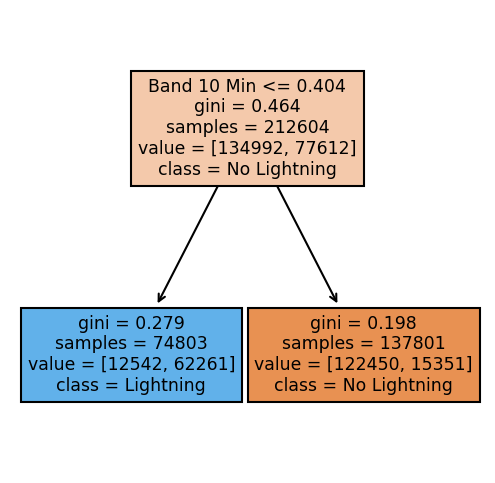

In [11]:
#Start with a single decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

clf = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best',max_depth=1,min_samples_split=4,min_samples_leaf=100)
clf1 = clf.fit(train_std_min_median, train_out)

model1_val_pred = clf1.predict(val_std_min_median)
cm = confusion_matrix(val_out, model1_val_pred)

print('Decision Tree with depth=1, Validation Set')
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, model1_val_pred),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, model1_val_pred),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, model1_val_pred),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, model1_val_pred),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, model1_val_pred),3)))
print('Accuracy: {}'.format(np.round(accuracy(cm),3)))
print('Precision: {}'.format(np.round(precision(cm),3)))
print('Recall: {}'.format(np.round(recall(cm),3)))
print('F1: {}'.format(np.round(f1(cm),3)))

model1_test_pred = clf1.predict(test_std_min_median)
cm = confusion_matrix(test_out, model1_test_pred)

print('')

print('Decision Tree with depth=1, Test Set')
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_out, model1_test_pred),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_out, model1_test_pred),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_out, model1_test_pred),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_out, model1_test_pred),3)))
print('AUC: {}'.format(np.round(roc_auc_score(test_out, model1_test_pred),3)))
print('Accuracy: {}'.format(np.round(accuracy(cm),3)))
print('Precision: {}'.format(np.round(precision(cm),3)))
print('Recall: {}'.format(np.round(recall(cm),3)))
print('F1: {}'.format(np.round(f1(cm),3)))

#Visualize simple decision tree

fn=['Band 8 STD','Band 9 STD','Band 10 STD','BAND 14 STD',\
    'Band 8 Min','Band 9 Min','Band 10 Min','BAND 14 Min',\
    'Band 8 Median','Band 9 Median','Band 10 Median','BAND 14 Median']
cn=['No Lightning','Lightning']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4),dpi=150)
tree.plot_tree(clf,
               feature_names = fn,class_names=cn,filled = True);
fig.savefig('single_decision_tree_max_depth=1.png')


RESULTS

Decision Tree with depth=1, Validation Set
Heidke Skill Score: 0.679
Pierce Skill Score: 0.678
Brier Score: 0.153
Brier Skill Score: 0.358
AUC: 0.839
Accuracy: 0.847
Precision: 0.809
Recall: 0.801
F1: 0.805

Decision Tree with depth=1, Test Set
Heidke Skill Score: 0.673
Pierce Skill Score: 0.667
Brier Score: 0.152
Brier Skill Score: 0.353
AUC: 0.833
Accuracy: 0.848
Precision: 0.813
Recall: 0.774
F1: 0.793


In [12]:
clf = RandomForestClassifier(n_estimators=10,random_state=0,criterion='entropy',max_depth=None,min_samples_split=4,min_samples_leaf=10)
clf2 = clf.fit(train_std_min_median, train_out)

model2_val_pred = clf2.predict(val_std_min_median)
cm = confusion_matrix(val_out, model2_val_pred)

print('Random forest with 100 trees, Validation Set')
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, model2_val_pred),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, model2_val_pred),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, model2_val_pred),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, model2_val_pred),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, model2_val_pred),3)))
print('Accuracy: {}'.format(np.round(accuracy(cm),3)))
print('Precision: {}'.format(np.round(precision(cm),3)))
print('Recall: {}'.format(np.round(recall(cm),3)))
print('F1: {}'.format(np.round(f1(cm),3)))

model2_test_pred = clf2.predict(test_std_min_median)
cm = confusion_matrix(test_out, model2_test_pred)

print('')

print('Random forest with 100 trees, Test Set')
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_out, model2_test_pred),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_out, model2_test_pred),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_out, model2_test_pred),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_out, model2_test_pred),3)))
print('AUC: {}'.format(np.round(roc_auc_score(test_out, model2_test_pred),3)))
print('Accuracy: {}'.format(np.round(accuracy(cm),3)))
print('Precision: {}'.format(np.round(precision(cm),3)))
print('Recall: {}'.format(np.round(recall(cm),3)))
print('F1: {}'.format(np.round(f1(cm),3)))

Random forest with 100 trees, Validation Set
Heidke Skill Score: 0.752
Pierce Skill Score: 0.754
Brier Score: 0.119
Brier Skill Score: 0.504
AUC: 0.877
Accuracy: 0.881
Precision: 0.847
Recall: 0.855
F1: 0.851

Random forest with 100 trees, Test Set
Heidke Skill Score: 0.742
Pierce Skill Score: 0.738
Brier Score: 0.12
Brier Skill Score: 0.486
AUC: 0.869
Accuracy: 0.88
Precision: 0.848
Recall: 0.827
F1: 0.838


RESULTS

Random forest with 100 trees, Validation Set
Heidke Skill Score: 0.752
Pierce Skill Score: 0.754
Brier Score: 0.119
Brier Skill Score: 0.504
AUC: 0.877
Accuracy: 0.881
Precision: 0.847
Recall: 0.855
F1: 0.851

Random forest with 100 trees, Test Set
Heidke Skill Score: 0.742
Pierce Skill Score: 0.738
Brier Score: 0.12
Brier Skill Score: 0.486
AUC: 0.869
Accuracy: 0.88
Precision: 0.848
Recall: 0.827
F1: 0.838

In [ ]:
ConvNet_mod = StandardConvNet(epochs=15, batch_size=128, filter_width=9, pooling='max',learning_rate=0.0001)
# Fit model and print architecture

ConvNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
print(ConvNet_mod.model.summary())

binary_threshold = 0.5
preds = ConvNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

cm = confusion_matrix(val_out, binary_preds)

print('Tuned CNN on validation set')
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Accuracy: {}'.format(np.round(accuracy(cm),3)))
print('Precision: {}'.format(np.round(precision(cm),3)))
print('Recall: {}'.format(np.round(recall(cm),3)))
print('F1: {}'.format(np.round(f1(cm),3)))

preds = ConvNet_mod.predict(scaled_test_in).reshape(test_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

cm = confusion_matrix(test_out, binary_preds)

print('Tuned CNN on validation set')
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(test_out, binary_preds),3)))
print('Accuracy: {}'.format(np.round(accuracy(cm),3)))
print('Precision: {}'.format(np.round(precision(cm),3)))
print('Recall: {}'.format(np.round(recall(cm),3)))
print('F1: {}'.format(np.round(f1(cm),3)))

{'loss': 0.10548894107341766, 'val_loss': 0.09930724650621414}
{'loss': 0.09172945469617844, 'val_loss': 0.0946585088968277}
{'loss': 0.08641630411148071, 'val_loss': 0.09719802439212799}
{'loss': 0.08194703608751297, 'val_loss': 0.08875937014818192}
{'loss': 0.07976702600717545, 'val_loss': 0.08910656720399857}
{'loss': 0.07804198563098907, 'val_loss': 0.0894903615117073}
